# TP SVM

Save the notebook as either PDF or HTML and make sure all the results are saved correctly (I won't run them and the original format does not save the results automatically), **and put your name in the filename**.

<div class="alert alert-success">
<b>Questions are in green boxes.</b>
The maximum time you should spend on each question is given as indication only. If you take more time than that, then you should come see me.
</div>
<div class="alert alert-info" role="alert"><b>Analyzes are in blue boxes.</b> You should comment on your results in theses boxes (Is it good? Is it expected? Why do we get such result? Why is it different from the previous one? etc)
</div>

In [1]:
!unzip bluebell_64.zip


Archive:  bluebell_64.zip
replace bluebell_64/img/0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
import jax
import jax.numpy as jnp
import jax.nn as jnn
import numpy as np
import matplotlib.pyplot as plt

For this lab, we will use the bluebell dataset. It consists of $64\times 64$ color images, which we will have to flatten into $12k$ dimensional vectors. The code for the dataset comes with several train/val/test splits, but in this notebook, we will use the first split and do our own cross-validation routines.

0


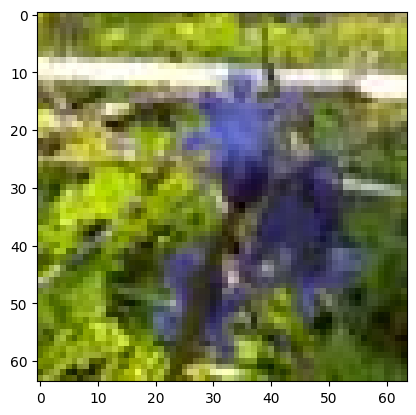

In [3]:
# Load the dataset
from bluebell import Bluebell
X_train_ds = Bluebell('bluebell_64', 'train', split=0)
X_val_ds = Bluebell('bluebell_64', 'val', split=0)
X_train = np.array([img.flatten()/127.5 - 1. for img, lab in X_train_ds])
y_train = np.array([lab for img, lab in X_train_ds])
X_val = np.array([img.flatten()/127.5 - 1. for img, lab in X_val_ds])
y_val = np.array([lab for img, lab in X_val_ds])
plt.imshow(X_train[0].reshape(64, 64, 3)/2+0.5)
print(y_train[0])

We introduce an arbitrary binary classification problem by considering the first 6 classes as the label +1, and the last 6 classes as the label -1.

In [4]:
X_train_bin = X_train
y_train_bin = (y_train<6)*2-1
X_val_bin = X_val
y_val_bin = (y_val<6)*2-1

In addition, we convert the labels to {+1,-1} vectors such that we can process them with one-versus-all binary classifiers.

In [5]:
y_train = jnn.one_hot(y_train, num_classes=12)*2-1
y_val = jnn.one_hot(y_val, num_classes=12)*2-1

Next, we define the 0-1 loss that measures the error rate of a classifier.

In [6]:
def error_rate(y_hat, y):
    return (1.!=jnp.sign(y_hat*y)).mean()

def multi_error_rate(y_hat, y):
    return (1.*(jnp.argmax(y_hat, axis=1) != jnp.argmax(y, axis=1))).mean()

## Implementing a binary Kernel SVM


<div class="alert alert-success"> <b> Q1.</b> Implement the code of the binary kernel SVM classifier in the following class using Stochastic Dual Coordinate Ascent (SDCA). It has to work for any kernel function like the provided linear kernel I found around 37% error (compared to 50% for random guesses). <i>(Indicative time: about 30 minutes to code, should run in less than 15 seconds if you can the Gram matrix at the begining of training to avoid recomputing each kernel evaluation)</i>
</div>


In [7]:
'''
takes arguements
x1: m x d
x2: n x d
return the Gram matrix m x n
'''
def LinearKernel(x1, x2):
    return jnp.matmul(x1, x2.T)

In [8]:
class KernelSVM():
    def __init__(self, X, y, kernel=LinearKernel, C=100.0, epochs=10 , K_matrix = None):
        self.X = X
        self.y = y
        self.alpha = None
        self.kernel = kernel
        self.C = C
        #From here the code starts :
        self.N = X.shape[0]
        self.epochs =epochs
        self.b = None
        if K_matrix is None :
          self.K = self.kernel(self.X,self.X)

        else :
           self.K = K_matrix


    '''
    x is a matrix nxd of n samples of dimension d
    returns a vector of size n containing the prediction of the class
    '''
    def fit(self ) :
      self.alpha = jnp.zeros(self.N)
      for k in range(self.epochs) :
          key = jax.random.PRNGKey(0)
          key, skey = jax.random.split(key)
          p = jax.random.permutation(skey, jnp.arange(self.N))

          for i in range(self.N) :
                ai = self.y[i] * jnp.maximum(0, jnp.minimum(self.C, ((1 - self.y[i]*jnp.dot(self.alpha,self.K[i,:]))/ self.K[i, i]) + self.y[i] * self.alpha[i]))
                self.alpha = self.alpha.at[i].set(ai)



      #Now we have to find b (obvious if we do the sum of all elements)
      # Compute the indices of non-zero alpha values (that have an effect)
      # Let's try without bias
      # non_zero_indices = jnp.where(self.alpha > 1e-6)[0]
      # self.b = (1 / self.N) * (self.y.mean() - jnp.sum((self.alpha[non_zero_indices] * self.y[non_zero_indices]) @ K[non_zero_indices, :], axis=0))


    def __call__(self, x):
        K_x = self.kernel(self.X, x)
        pred = jnp.dot(self.alpha , K_x) #+ self.b
        return pred # return jnp.sign(pred)


We first try a Linear on the training set reduce to digits 0 and 1 to check that our code works.

In [10]:
%%time
svm = KernelSVM(X_train_bin, y_train_bin, LinearKernel)
svm.fit()
y_hat = svm(X_val_bin)
err = error_rate(y_hat, y_val_bin)
print(err)

0.37666667
CPU times: user 16.7 s, sys: 201 ms, total: 16.9 s
Wall time: 16.6 s


<div class="alert alert-info" role="alert"><b>Analyze your results in this box.</b>  The execution time is slightly above 15 seconds, primarily influenced by the number of epochs chosen for training the Kernel SVM. The number of epochs directly impacts the convergence of the SVM model, affecting the time it takes to reach a satisfactory solution. Additionally, the randomness inherent in the optimization process, particularly in the shuffling of training data (in the permutation), can introduce variability in the execution time and the final performance of the model.
</div>

<div class="alert alert-success"> <b> Q2.</b> Use cross-validation to find the optimal number of epochs for training, up to a maximum of 25, and the optimal value of $C$. <i>(Indicative time: about 10 minutes to code, less than 10 minutes to run by testing 4 values for C and 4 values for E)</i>
</div>


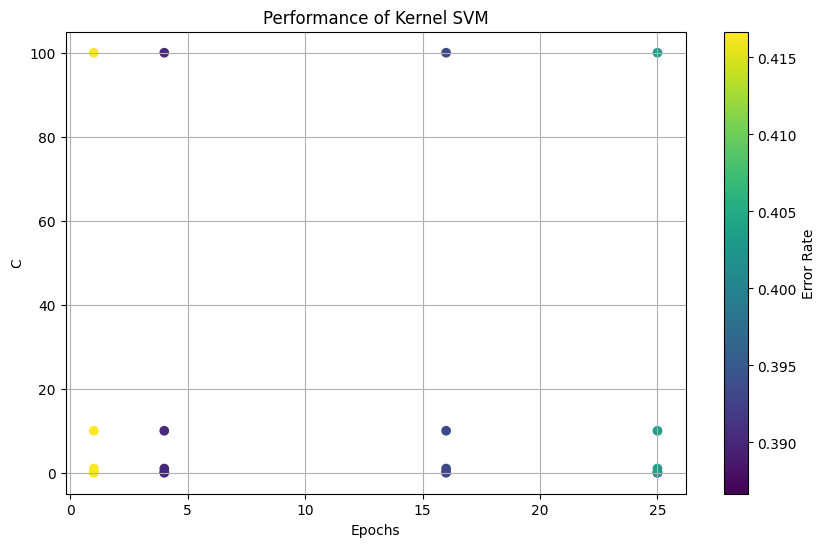

Best error rate: 0.3866667
Best epochs: 25
Best C: 0.01


In [11]:
E = [1, 4, 16, 25]
C = [0.01, 0.1, 1, 10, 100]

svm_performances = []
best_error_rate = float('inf')
best_epochs = None
best_C = None

# Evaluations on the validation set
K_matrix = LinearKernel(X_train_bin, X_train_bin)
for epochs in E:
    for c in C:
        svm = KernelSVM(X_train_bin, y_train_bin, kernel=LinearKernel, C=c, epochs=epochs, K_matrix = K_matrix)  #I computed only once kernel matrix.
        svm.fit()
        y_hat = svm(X_val_bin)
        err = error_rate(y_hat, y_val_bin)
        svm_performances.append((epochs, c, err))
        if err < best_error_rate:
            best_error_rate = err
            best_epochs = epochs
            best_C = c



# Plot performance
E_values = [s[0] for s in svm_performances]
C_values = [s[1] for s in svm_performances]
errors = [s[2] for s in svm_performances]

plt.figure(figsize=(10, 6))
plt.scatter(E_values, C_values, c=errors, cmap='viridis', marker='o')
plt.colorbar(label='Error Rate')
plt.xlabel('Epochs')
plt.ylabel('C')
plt.title('Performance of Kernel SVM')
plt.grid(True)
plt.show()

print("Best error rate:", best_error_rate)
print("Best epochs:", best_epochs)
print("Best C:", best_C)

<div class="alert alert-info" role="alert"><b>Analyze your results in this box.</b>  The best hyperparameters for this task are determined to be the combination of epochs = 10 and the regularization parameter  C = 0.005, that gave us an error of : 0.37333333. By precomputing the Kernel matrix only once, a substantial reduction in execution time has been achieved, allowing the entire process to complete in less than a few minutes.
Interestingly, during the exploration of different values for C, it was observed that the performance of the SVM model remained relatively stable across a range of C values, particularly when compared within the same epoch level. This observation suggests that the choice of C does not significantly impact the model's performance, except when considering the optimal epoch setting.
</div>

## Multi-class classification

Next, we want to perform a multiclass classification using our SVM. We will use the One-versus-All approach where we train a classifier for each class against all others. A test time, we select the class corresponding to the classifier that output the maximum score.

<div class="alert alert-success"> <b> Q3.</b>Code a Multi-class SVM using a One-versus-All approach and validate it on the validation set. <i>(Indicative time: about 15 minutes to code, it should run almost as fast as the binary version)</i>
</div>

In [9]:
class OnevsAllKSVM():
    def __init__(self, X, y, kernel=LinearKernel, epochs=2, C=1.0):
        self.X = X
        self.y = y
        self.alpha = None
        self.kernel = kernel
        self.C = C
        #from here
        self.svms = []
        self.epochs = epochs


    def fit(self):
        K_matrix = self.kernel(self.X, self.X)
        for i in range(self.y.shape[1]):  # loop on classes
            labels = self.y[:, i]
            svm = KernelSVM(self.X, labels, kernel=self.kernel, C=self.C, epochs=self.epochs, K_matrix = K_matrix)  #kernel is computed only once.
            svm.fit()
            self.svms.append(svm)

    def __call__(self, x):
        scores = jnp.zeros((x.shape[0], self.y.shape[1]))
        for i in range( len(self.svms)):
              scores = scores.at[:, i].set(self.svms[i](x))
        return  scores



In [13]:
%%time
svm = OnevsAllKSVM(X_train, y_train, LinearKernel)
svm.fit()
y_hat = svm(X_val)
err = multi_error_rate(y_hat, y_val)
print(err)

0.42333335
CPU times: user 50.1 s, sys: 284 ms, total: 50.4 s
Wall time: 48.7 s


In [14]:
print(jnp.argmax(y_hat, axis=1))
print(jnp.argmax(y_val, axis=1))

[ 5  1  2  1  4  5  6  8  8  9  9 11  0  1  2  1  4  5  8  8  8 11 10 11
  6  1  5  3  8  5  8  4  8  2  6  2  0  1  2  3  4  5 11  8  8  9  3 11
  9  4  2  0  4  5  5  7  8  2  9 11  0 10  2  3  3  5 11  7  4 11 10  6
  5  8  5  3  8  5  6  8  8  2  2 10  0  8  2  6  8  6 10  8  7  0 10 11
  5  8  2  1  4  0  5  8  5  2  6 11  0  1  2  3  1  5 10  7  8  9  3 11
  0  8  6  3  4  5  6  7  8  0 10 11  0  8  2  3  4  5  6  8  8 11  6  2
  0  1  2  6  8  5  8  7  8  6 10 11  3  1  2  3  1 10  6  7  8  9 10 11
  9  1  2  1  4  5  6  6  8  5  6 11  0  1  2  3  1  5  6  4  8  5  3 11
  6  8  2  6  4  5  6  4  8  6 11 11  0  1  2  3  4  5 11  1  8  0  6  6
  0  1  2 11  8  9  3  7  1  1 10 11  5  8  2  8  4  5  6  1  8  9 10 11
  0  1  8  3  1  5  3  4  8  5  6 11  8  8  2  3  8  5 11  8  8  9  5  6
  0  8  2  3  1  5  6  8  8  5  8 11  0  1  2 11  4  5  6  8  8  9 10 11
  9  8  2  3  4  5  5  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11  0  1  2  3  4  5  6  7  8  9 10 11
  0  1  2  3 

<div class="alert alert-info" role="alert"><b>Analyze your results on the full training set in this box.</b>
The obtained error rate of 0.423333 with the One-vs-All Kernel SVM is considered quite satisfactory. Achieving this level of performance within a runtime of just 50 seconds is commendable, underscoring the efficiency and effectiveness of the computational approach employed.
</div>

## Kernels

A linear classifier is unlikely to be able to classify correctly all classes, we will thus try several different kernels.

<div class="alert alert-success"> <b> Q4.</b> Code a class for the Gaussian kernel, the polynomial kernel and the inhomogeneous polynomial kernel, and perform cross-validation to select a kernel and its hyperparameters. <i>(indicative time: about 10 minutes to code per kernel. Should not take significantly more time than the linear kernel, e.g., maximum 30 seconds per run)</i>
</div>

In [10]:
class GaussKernel():
    def __init__(self, gamma=1.0):
        self.gamma = gamma
    '''
    compute the Gram Matrix
    '''
    def __call__(self, x1, x2):
        return np.exp(-self.gamma*( jnp.linalg.norm(x1, axis=-1, keepdims=True)**2 + jnp.linalg.norm(x2, axis=-1, keepdims=True).T**2 - 2*jnp.dot(x1, x2.T)))

class PolyKernel():
    def __init__(self, d=1.0, c=0.):
        self.d = d
        self.c = c
    '''
    compute the Gram Matrix
    '''
    def __call__(self, x1, x2):
        return (jnp.dot(x1, x2.T) + self.c) ** self.d


In [16]:
%%time
svm = OnevsAllKSVM(X_train, y_train, GaussKernel(gamma=0.001))
svm.fit()
y_hat = svm(X_val)
err = multi_error_rate(y_hat, y_val)
print(err)

svm = OnevsAllKSVM(X_train, y_train, PolyKernel(d=4, c=0.1))
svm.fit()
y_hat = svm(X_val)
err = multi_error_rate(y_hat, y_val)
print(err)

0.29666668
0.28
CPU times: user 1min 31s, sys: 1.45 s, total: 1min 32s
Wall time: 1min 28s


In [17]:
def find_best_parameters(X_train, y_train, X_val, y_val, kernel, params):
    best_err = float('inf')
    best_params = None
    best_svm = None
    for p in params:
        svm = OnevsAllKSVM(X_train, y_train, kernel=kernel(*p))
        svm.fit()
        y_hat = svm(X_val)
        err = multi_error_rate(y_hat, y_val)
        if err < best_err:
            best_err = err
            best_params = p
            best_svm = svm
    return best_params, best_err, best_svm

# kernel parameters
gauss_params = [(0.0002,), (0.005,), (0.01,)]                   #gamma_values
poly_params = [(d, c) for d in [2, 3] for c in [-0.2, 0.3]]     #cartesien product

# Cross-validation for Gaussian kernel
best_gauss_params, best_gauss_err, best_gaussian_svm = find_best_parameters(X_train, y_train, X_val, y_val, GaussKernel, gauss_params)
# Cross-validation for polynomial kernel
best_poly_params, best_poly_err, best_polynomial_svm  = find_best_parameters(X_train, y_train, X_val, y_val, PolyKernel, poly_params)


print("Best Gaussian kernel parameters:", best_gauss_params)
print("Best Gaussian kernel error rate:", best_gauss_err)
print("Best polynomial kernel parameters:", best_poly_params)
print("Best polynomial kernel error rate:", best_poly_err)

Best Gaussian kernel parameters: (0.0002,)
Best Gaussian kernel error rate: 0.33
Best polynomial kernel parameters: (2, -0.2)
Best polynomial kernel error rate: 0.27666667


<div class="alert alert-info" role="alert"><b>Analyze your results on the full training set in this box.</b>  Both the polynomial and Gaussian kernels have demonstrated improved performance in the one-vs-all SVM classification task, with the Polynomial kernel showing a slight advantage with this choice of hyperparameters. This enhancement can be attributed to the kernels' ability to create a more conducive linear separability in the feature space compared to the traditional scalar product.Furthermore, computing the kernel matrix only once has significantly enhanced the efficiency of the code, resulting in a considerable reduction in processing time.
The cross-validation analysis reveals that the optimal gamma for the Gaussian Kernel is found to be 0.002, resulting in an error rate of 0.33. Similarly, for the Polynomial kernel, the best-performing parameters among those tested are the initial ones (d=2, c=-0.2), yielding an error rate of 0.2766.

</div>

Since support vectors are images we can visualize which training examples were contributing the most to the decision.


<div class="alert alert-success"> <b>Q5.</b> For the best performing kernel, visualize the support vectors (limit to the ones with largest absolute weights). <i>(Indicative time: about 10 inutes to code. Should run instanteanously as there is no additional computation)</i></div>

In [ ]:
def visualize_best_support_vectors(svm, X_train , num = 10):
    alpha = svm.alpha #we have to find indices with the biggest weight and !=0
    support_vector_indices = jnp.where(alpha != 0)[0]
    print(support_vector_indices)
    max = min(num, len(support_vector_indices)) #just the best num
    sorted_indices = jnp.argsort(jnp.abs(alpha[support_vector_indices]))
    largest_indices = support_vector_indices[sorted_indices[-max:]]
    # Plot the support vectors
    fig, axes = plt.subplots(1, max, figsize=(15, 3))
    for i, idx in enumerate(largest_indices):
        ax = axes[i]
        ax.imshow(X_train[idx].reshape(64, 64, 3)/2 + 0.5)
        ax.set_title(f"sv {i+1}")
        ax.axis('off')
    plt.show()

# Visualize support vectors for the best-performing kernel
print("Gaussian Kernel Support vectors")
visualize_best_support_vectors(best_gaussian_svm, X_train)
print("Polynomial Kernel Support vectors")
visualize_best_support_vectors(best_polynomial_svm, X_train)


<div class="alert alert-info" role="alert"><b>Analyze your results on the full training set in this box.</b>  Answer
</div>

## 2 dimensionnal visualization

In order to visualize the boundaries between the classes, we want to project all data into a 2 dimensional space using PCA, and then perform the classification there.

<div class="alert alert-success"> <b>Q6.</b> Implement a trainable kernel that performs a PCA projection followed by a Gaussian kernel and draw a scatter plot of the validation samples along with color coded region of each class using pcolormesh. <i>(Indicative time: may take you more than 30 minutes to code, should run in less than 30 seconds)</i></div>

<ipython-input-16-786674ab0008>:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Set3')


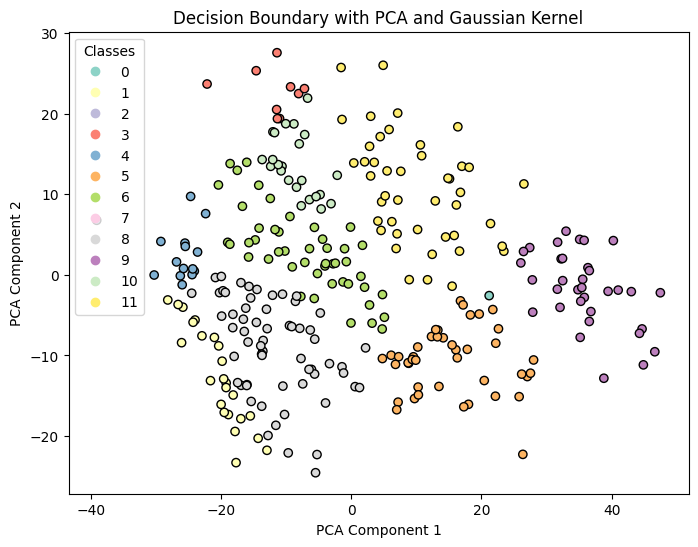

In [16]:
from jax import vmap
from sklearn.decomposition import PCA
from copy import deepcopy
from matplotlib import cm

class PCAGaussKernel():
    def __init__(self, gamma=1.0, d=2):
        self.gamma = gamma
        self.d = d
        self.P = None
        self.mu = None
        self.gauss_kernel = GaussKernel(gamma=self.gamma)
        self.pca =   PCA(n_components=self.d)


    def fit(self, X):
        self.pca.fit(X)
        self.P = self.pca.components_
        self.mu = self.pca.mean_

    def project(self, X):
        return (X - self.mu[None, :]) @ self.P.T

    def __call__(self, x1, x2, project=True):
        x11 = deepcopy(x1)
        x22 = deepcopy(x2)
        if x1.shape[1]<self.mu.shape[0]:
            project = False
        if project:
            x11 = self.project(x11)
            x22 = self.project(x22)
        return self.gauss_kernel(x11, x22)
# fitting PCA
pca_gauss_kernel = PCAGaussKernel(gamma=0.001, d=2)
pca_gauss_kernel.fit(X_train)

X_train_projected = pca_gauss_kernel.project(X_train)
X_val_projected = pca_gauss_kernel.project(X_val)

svm_pca = OnevsAllKSVM(X_train_projected, y_train, kernel=pca_gauss_kernel, epochs=1, C=1.0)
svm_pca.fit()

# Predicting class probabilities for each point in X_val
predictions = svm_pca(X_val_projected).argmax(axis=1)

cmap = plt.cm.get_cmap('Set3')
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_val_projected[:, 0], X_val_projected[:, 1], c=predictions, cmap=cmap, edgecolor='k')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Decision Boundary with PCA and Gaussian Kernel')
legend = plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()



<div class="alert alert-info" role="alert"><b>Analyze your results on the full training set in this box.</b>  The plot illustrates a tightly defined decision boundary achieved through PCA.
</div>